In [145]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [147]:
session = "JP031211"
# session = "LP041310"

parent_folder = "/home/adameisen/millerdata/common/datasets/sspa"
uncut_file = os.path.join(parent_folder, 'mat_uncut', session + '.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = loadmat(uncut_file, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo'], verbose=False)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 49.68 seconds)


# VAR

In [216]:
data_path = "../../__data__/VAR/sspa_uncut"
os.makedirs(data_path, exist_ok=True)

T = lfp.shape[0] # number of time points
N = lfp.shape[1] # number of electrodes
dt = lfp_schema['smpInterval'][0]

PCA_dim = -1
end_step = int(T - (10/0.001)) # don't analyze last 10 seconds

results = {}
for window in [5]:
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
    stride = 0.2
    
    areas = np.unique(electrode_info['area'])
    unit_indices = np.arange(N)[pd.Series(electrode_info['area']).isin(areas)]
#     unit_indices = np.arange(N)

    # UNCUT DATA
    print("Analyzing uncut data ...")
    results['pre'] = {}
    data = lfp[:end_step, unit_indices]
    data = data[np.isnan(data).sum(axis=1) == 0]
    results['data'] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, return_A=True, PCA_dim=PCA_dim, verbose=True)
    
    results['params'] = {}
    results['params']['PCA_dim'] = PCA_dim
    results['params']['window'] = window
    results['params']['stride'] = stride
    results['params']['uncut_file'] = uncut_file
    results['params']['end_step'] = end_step
    
    save(results, os.path.join(data_path, f"results_{session}_window_{window}_stride_{stride}"))

Analyzing uncut data ...


  0%|          | 0/72660 [00:00<?, ?it/s]

In [268]:
data_path = "../../__data__/VAR/sspa_uncut"
results = load(os.path.join(data_path, "results_JP031211_window_2.5_stride_0.2"))

# Plotting

In [217]:
trial_bool = np.zeros(results['params']['end_step'])
for t in trial_info['sampleOn'][~np.isnan(trial_info['sampleOn'])]:
    trial_bool[int((t - 2)/dt):int((t + 3)/dt)] = 1
    
fixpt_bool = np.zeros(results['params']['end_step'])
for t in trial_info['fixptOn'][~np.isnan(trial_info['fixptOn'])]:
    fixpt_bool[int(t/dt):int((t + 0.5)/dt)] = 1
    
sample_bool = np.zeros(results['params']['end_step'])
for t in trial_info['sampleOn'][~np.isnan(trial_info['sampleOn'])]:
    sample_bool[int(t/dt):int((t + 0.5)/dt)] = 1
    
test_bool = np.zeros(results['params']['end_step'])
for t in trial_info['testOn'][~np.isnan(trial_info['testOn'])]:
    test_bool[int(t/dt):int((t + 0.5)/dt)] = 1

test2_bool = np.zeros(results['params']['end_step'])
for t in trial_info['testOn2'][~np.isnan(trial_info['testOn2'])]:
    test2_bool[int(t/dt):int((t + 0.5)/dt)] = 1
    
response_bool = np.zeros(results['params']['end_step'])
if np.isnan(trial_info['responseDone']).sum() > np.isnan(trial_info['responseTime']).sum():
    nan_indices = np.isnan(trial_info['responseDone'])
else:
    nan_indices = np.isnan(trial_info['responseTime'])
for t_start, t_end in zip(trial_info['responseTime'][~nan_indices], trial_info['responseDone'][~nan_indices]):
    response_bool[int(t_start/dt):int(t_end/dt)] = 1

reward_bool = np.zeros(results['params']['end_step'])
for t in trial_info['rewardOn'][~np.isnan(trial_info['rewardOn'])]:
    reward_bool[int(t/dt):int((t + 0.002)/dt)] = 1

In [218]:
area_criticalities = {}
for area_set in tqdm([('PFCv',), ('PFCd',), ('PFCv', 'PFCd')]):
# for area_set in tqdm([('PFCv', 'PFCd')]):
    indices = (pd.Series(electrode_info['area']).isin(area_set)).to_numpy()
    A_mats = np.array([A[indices][:, indices] for A in results['data']['A_mats']])
    area_criticalities[area_set] = np.zeros((A_mats.shape[0], A_mats.shape[1]))
    for i, A in enumerate(A_mats):
        e, _ = np.linalg.eig(A)
        area_criticalities[area_set][i] = np.abs(e)

  0%|          | 0/3 [00:00<?, ?it/s]

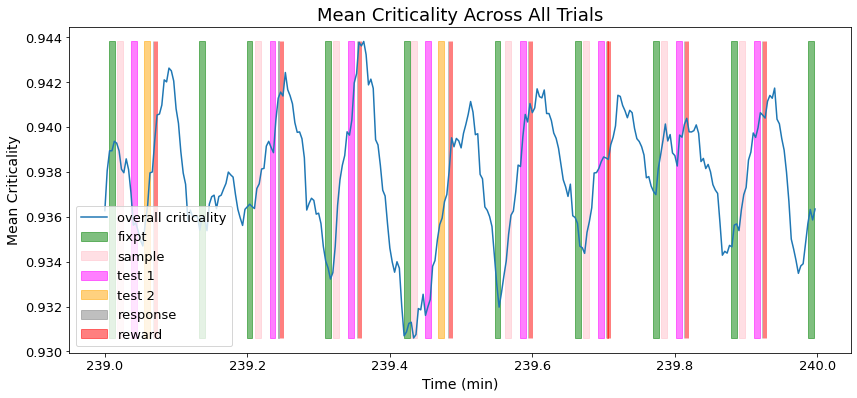

In [269]:
xlim_mins = [239, 240] # minutes
midpoint = False


# xlim = [int(xlim_mins[0]*60/stride), int(xlim_mins[1]*60/stride)]
# xlim_dt = [int(xlim_mins[0]*60/dt), int(xlim_mins[1]*60/dt)]
plt.figure(figsize=(14, 6))

if midpoint:
    start_times = ((np.arange(results['data']['eigs'].shape[0])*results['params']['stride'] + results['params']['window']/2)/60)
#     xlim_dt = [xlim_dt[0] + int(window/(2*dt)), xlim_dt[1] + int(window/(2*dt))]
else:
    start_times = np.arange(results['data']['eigs'].shape[0])*results['params']['stride']/60

xlim = [np.argmax(start_times >= xlim_mins[0]), np.argmax(start_times >= xlim_mins[1])] 
    
min_val = np.Inf
max_val = -np.Inf

# PLOT CRITICALITIES
criticalities = results['data']['eigs'][xlim[0]:xlim[1]].mean(axis=1)
if criticalities.min() < min_val:
    min_val = criticalities.min()
if criticalities.max() > max_val:
    max_val = criticalities.max()
plt.plot(start_times[xlim[0]:xlim[1]], criticalities, label='overall criticality')

# # PLOT AREA CRITICALITIES
# for area_set in area_criticalities.keys():
#     criticalities = area_criticalities[area_set][xlim[0]:xlim[1]].mean(axis=1)
#     plt.plot(start_times[xlim[0]:xlim[1]], criticalities, label=area_set)
#     if criticalities.min() < min_val:
#         min_val = criticalities.min()
#     if criticalities.max() > max_val:
#         max_val = criticalities.max()
        
plt.xlabel('Time (min)', fontsize=14)
plt.ylabel('Mean Criticality', fontsize=14)
fill_times = np.arange(results['params']['end_step'])*dt/60
xlim_dt = [np.argmax(fill_times >= xlim_mins[0]), np.argmax(fill_times >= xlim_mins[1])] 
# trial
# plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=trial_bool[xlim_dt[0]:xlim_dt[1]], color='pink', alpha=0.5, label='trial')
# fixpt
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=fixpt_bool[xlim_dt[0]:xlim_dt[1]], color='green', alpha=0.5, label='fixpt')
# sample
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=sample_bool[xlim_dt[0]:xlim_dt[1]], color='pink', alpha=0.5, label='sample')
# test 1
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=test_bool[xlim_dt[0]:xlim_dt[1]], color='magenta', alpha=0.5, label='test 1')
# test 2
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=test2_bool[xlim_dt[0]:xlim_dt[1]], color='orange', alpha=0.5, label='test 2')
# response
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=response_bool[xlim_dt[0]:xlim_dt[1]], color='gray', alpha=0.5, label='response')
# reward
plt.fill_between(fill_times[xlim_dt[0]:xlim_dt[1]], min_val, max_val, where=reward_bool[xlim_dt[0]:xlim_dt[1]], color='red', alpha=0.5, label='reward')
ax = plt.gca()
# ax.set_yscale('log')
ax.tick_params(labelsize=13)
plt.title('Mean Criticality Across All Trials', fontsize=18)
plt.legend(fontsize=13)
# plt.xlim(xlim_mins)
plt.show()